<a href="https://colab.research.google.com/github/rory-smith/Lectures-on-inference-in-GW-astronomy/blob/master/GW_inference_in_a_toy_universe_probability_as_counting_and_computation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests, os
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'


In [2]:
!pip install lalsuite

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 48.3 MB 77 kB/s 
     |████████████████████████████████| 51 kB 4.5 MB/s 
     |████████████████████████████████| 1.4 MB 39.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 55 kB 4.0 MB/s 
     |████████████████████████████████| 295 kB 66.7 MB/s 
     |████████████████████████████████| 4.1 MB 52.8 MB/s 
  Created wheel for ligo-segments: filename=ligo_segments-1.4.0-cp37-cp37m-linux_x86_64.whl size=86644 sha256=5574fbfb7ba20bc46c3f769e136e55bf67426a1b79269e0b786836999b9e390c
  Stored in directory: /root/.cache/pip/wheels/09/f9/d4/129b3bb4458d50b56fdc8245ace7c8216d54865fe8d3aebc05
  Created wheel for lscsoft-glue: filename=lscsoft_glue-3.0.1-cp37-cp37m-linux_x86_64.whl size=258462 sha256=1eda91ea71264741467523604a9c7c7777b14bc67

In [3]:
!pip install latex

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for latex: filename=latex-0.7.0-py3-none-any.whl size=7604 sha256=a826814ca56274d06fc6ad21d8de5d17378cab8e810fb2a4e5fa5e452f107dbb
  Stored in directory: /root/.cache/pip/wheels/57/d6/11/5d5718227890d9e479b6137cb406410c37a0b84b2ab35b872b
  Created wheel for data: filename=data-0.4-py3-none-any.whl size=7247 sha256=dbeb6eb177f95ce8eb3c45ef3a456c32b4dca1e9e6f6e91843e41e855248b461
  Stored in directory: /root/.cache/pip/wheels/28/76/4b/7db27e02c1de4d2181559d108fcdfed1680ff7d3534553d460
  Created wheel for shutilwhich: filename=shutilwhich-1.1.0-py3-none-any.whl size=2781 sha256=1efdcfe3c0d88c6103131e478bd4b01f6cec578febfd72468fb9c83d4380e027
  Stored in directory: /root/.cache/pip/wheels/4c/c0/ce/5a47f35186acbe73e38811df30daaf798c81a7599bb2d5995a
  Created wheel for tempdir: filename=tempdir-0.7.1-py3-none-any.whl size=2214 sha256=3aafc8c54d9f4607810ac53221c22ef5db53e03e47212

In [4]:
import lalsimulation as lalsim
import numpy as np
from scipy import stats
import pylab as plt
import lal
import pandas as pd
from scipy.special import logsumexp

In [5]:
data_frequency = 150 # In our universe, GW detectors only record data at 150Hz :)

###################################################################################################
### This function draws random noise with the right statistics ###
### In the frequency domain, LIGO/Virgo noise has mean zero and variance proportional
### to the noise PSD (real and imag parts are identially and independently distributed) 
###################################################################################################

def GW_detector_noise(N):


  deltaF = 1/4.
  noise_mean = 0
  noise_var = lalsim.SimNoisePSDaLIGOZeroDetLowPower(data_frequency) / (4*deltaF)

  noise_re = np.random.normal(loc=noise_mean, scale=np.sqrt(noise_var), size=int(N))
  noise_imag = np.random.normal(loc=noise_mean, scale=np.sqrt(noise_var), size=int(N))

  return noise_re + 1j*noise_imag

In [6]:
###################################################################################################
### This draws random samples of BBH masses. In our Universe, BBH masses are distributed according
### to a truncated normal distribution. You can change this to whatever you like ##################
###################################################################################################
def draw_mtotal(N):

  mtot_min = 30
  mtot_max = 100
  mtot_mean = 60
  mtot_var = 10
  a = (mtot_min-mtot_mean)/np.sqrt(mtot_var) # some annoying parameter for scipy function
  b = (mtot_max-mtot_mean)/np.sqrt(mtot_var)
  return stats.truncnorm.rvs(a, b, loc=mtot_mean, scale=np.sqrt(mtot_var),size=int(N))

In [8]:
# this is all bookkeepy stuff to allow us to evaluate a GW signal at GW frequency of 150Hz #####
f = np.array([data_frequency])
F = f#np.loadtxt("Freqs_long.txt")
F = lal.CreateREAL8Vector(len(F))
F.data[:] =  f
###############################################################################
def GW_signal(Mtotal):

  mass_ratio = 1 #all binaries in our universe contain equal-mass black holes
  Dist = 1e6*lal.lal.PC_SI #all binary black holes are located 0.1Gpc from our detector
  spin1x, spin1y, spin1z = 0, 0, 0 #black holes do not spin in our Universe
  spin2x, spin2y, spin2z = 0, 0, 0 #black holes do not spin in our Universe
  iota = 0 #all BBH obits are inclined such that their orbital plane is "face on"

  m1, m2 = Mtotal/(1+mass_ratio), Mtotal/(1+mass_ratio)

  m1 *= lal.lal.MSUN_SI #component mass into SI units
  m2 *= lal.lal.MSUN_SI
  WFdict = lal.CreateDict() #bookkeepy thing
  h = lalsim.SimIMRPhenomXPHMFrequencySequence(F, m1, m2, spin1x, \
            spin1y, spin1z, spin2x, spin2y, spin2z, Dist, iota, 0, 150, WFdict)
  
  signal = h[0].data.data + h[1].data.data #equal parts plus and cross polarization
  return signal

In [7]:
###################################################################################################
### These are the probability densities for the likelihood function, prior probability of the BBH
### masses, and the evidence. They are the mathematical functions that are used to construct the 
### posterior probabiltiy density of the BBH masses given some data ###############################
################################################################################################### 

## ln likelihood for the real part of the data #####################################################
###################################################################################################

def lnL_re(data,signal): 
  deltaF = 1/4.
  noise_var = lalsim.SimNoisePSDaLIGOZeroDetLowPower(data_frequency) / (4*deltaF)


  data_real = np.real(data)
  return stats.norm.logpdf(data_real, loc=signal.real, scale=np.sqrt(noise_var))

## ln likelihood for the imaginary part of the data ################################################
###################################################################################################

def lnL_im(data,signal):
  deltaF = 1/4.
  noise_var = lalsim.SimNoisePSDaLIGOZeroDetLowPower(data_frequency) / (4*deltaF)
  
  data_imag = np.imag(data)
  return stats.norm.logpdf(data_imag, loc=signal.imag, scale=np.sqrt(noise_var))

## ln likelihood for the full complex data, d= re(data) + im(data) #################################
###################################################################################################
def lnL(data,mtotal):
  signal = GW_signal(mtotal)[0] 
  ln_L_re = lnL_re(data,signal)
  ln_L_im = lnL_im(data,signal)

  return ln_L_re + ln_L_im

## ln likelihood for the hypothesis d=noise (i.e., no sigial) #####################################
###################################################################################################
def lnL_noise_only(data):
  signal = 0
  ln_L_re = lnL_re(data,signal)
  ln_L_im = lnL_im(data,signal)

  return ln_L_re + ln_L_im

### ln prior probability density ###################################################################
####################################################################################################
def lnpi(mtotal):
  mtot_min = 30
  mtot_max = 100
  mtot_mean = 60
  mtot_var = 10
  a = (mtot_min-mtot_mean)/np.sqrt(mtot_var) # some annoying parameter for scipy function
  b = (mtot_max-mtot_mean)/np.sqrt(mtot_var)
  return stats.truncnorm.logpdf(mtotal,a, b, loc=mtot_mean, scale=np.sqrt(mtot_var))

### ln posterior probability density (un-normalized!) ##############################################
####################################################################################################
def ln_p_mtotal_given_data(mtotal, data):

  return lnpi(mtotal) + lnL(data, mtotal)
### ln evidence ####################################################################################
####################################################################################################
def ln_Z(ln_posterior,dx):

  return logsumexp(ln_posterior,b=dx)


In [9]:
### Create some GW detector noise! ################################################################
###################################################################################################

noise_measurements = GW_detector_noise(5e6)

In [10]:
### Populate the Universe with BBH's (endow them with total masses) ###############################
###################################################################################################
BBH_masses = draw_mtotal(5e6)

In [11]:
### Now create the GW signals associated with our merging BBHs ####################################
###################################################################################################
signals = np.array([GW_signal(_m)[0] for _m in BBH_masses])

In [12]:
### Finally, add the signal to the noise to make the strain data (d=s+n)###########################
###################################################################################################

strain_data = signals + noise_measurements

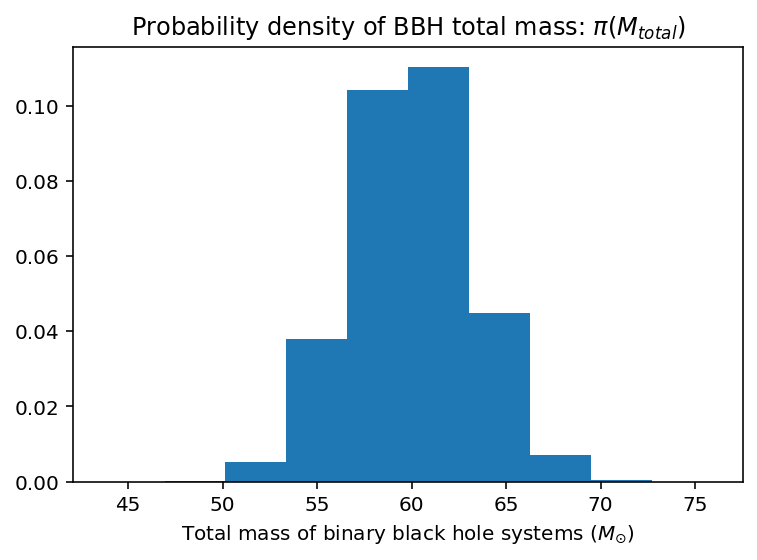

In [13]:
plt.hist(BBH_masses, density=True)
plt.xlabel(r"Total mass of binary black hole systems $(M_{\odot})$")
plt.title(r"Probability density of BBH total mass: $\pi(M_{total})$")
plt.show()

In [14]:
## bundle up our data, noise, masses into a pandas data frame 
_df = {'total mass':BBH_masses, 'strain_data':strain_data, 'noise':noise_measurements, 'signal':signals}
dataframe = pd.DataFrame(data=_df)

In [15]:
dataframe

,total mass,strain_data,noise,signal
0,58.809618,-4.235488e-21+7.306925e-24j,-8.976000e-24-1.303291e-23j,-4.226512e-21+2.033984e-23j
1,58.338145,-4.186035e-21+2.053758e-23j,-1.652718e-24+6.588610e-25j,-4.184382e-21+1.987872e-23j
2,58.835218,-4.222115e-21+1.589955e-23j,6.694340e-24-4.465539e-24j,-4.228810e-21+2.036509e-23j
3,60.325916,-4.360280e-21+3.048345e-23j,4.104047e-24+8.605791e-24j,-4.364384e-21+2.187766e-23j
4,56.805371,-4.057972e-21+2.601915e-23j,-8.203697e-24+7.593460e-24j,-4.049769e-21+1.842569e-23j
...,...,...,...,...
4999995,56.085442,-3.994697e-21+3.059569e-23j,-6.944437e-24+1.283151e-23j,-3.987753e-21+1.776418e-23j
4999996,64.734623,-4.776371e-21+1.860445e-23j,1.039727e-23-8.417486e-24j,-4.786768e-21+2.702193e-23j
4999997,58.875918,-4.233278e-21+1.169464e-23j,-8.134373e-25-8.710640e-24j,-4.232465e-21+2.040528e-23j
4999998,55.237995,-3.913463e-21-3.785737e-24j,2.248784e-24-2.078575e-23j,-3.915712e-21+1.700001e-23j


In [16]:
mtotal_new = 59 
strain_data_new = GW_detector_noise(1) + GW_signal(mtotal_new)

In [17]:
precision = 24 #number of decimal places to round data

idx = np.where(np.around(strain_data,precision)==np.around(strain_data_new, precision))

In [18]:
# the part of the dataframe where the strain data equals the new data (to our set precision)
measurement_table = dataframe[dataframe.index.isin(idx[0])]

In [19]:
# this contains the total masses that produce strain data equal to what we just "measured"
# with this, we can estimate the probability of a the total mass given our newly measured data by counting  
measurement_table

,total mass,strain_data,noise,signal
740,59.011351,-4.242586e-21+2.061235e-23j,2.059245e-24+7.291409e-26j,-4.244645e-21+2.053944e-23j
32501,59.045002,-4.242644e-21+2.109950e-23j,5.031684e-24+5.266275e-25j,-4.247676e-21+2.057287e-23j
43833,58.883484,-4.242686e-21+2.122186e-23j,-9.542049e-24+8.091009e-25j,-4.233144e-21+2.041276e-23j
51467,58.935940,-4.243320e-21+2.106446e-23j,-5.461284e-24+5.998006e-25j,-4.237859e-21+2.046466e-23j
64740,58.979831,-4.242882e-21+2.124412e-23j,-1.074826e-24+7.359642e-25j,-4.241807e-21+2.050816e-23j
...,...,...,...,...
4882583,59.095116,-4.242833e-21+2.130841e-23j,9.359901e-24+6.856677e-25j,-4.252193e-21+2.062274e-23j
4907625,59.144079,-4.242751e-21+2.089493e-23j,1.385919e-23+2.233831e-25j,-4.256610e-21+2.067155e-23j
4907997,58.890175,-4.242988e-21+2.089695e-23j,-9.242548e-24+4.775798e-25j,-4.233745e-21+2.041937e-23j
4912474,59.099368,-4.242937e-21+2.079302e-23j,9.639164e-24+1.660469e-25j,-4.252576e-21+2.062697e-23j


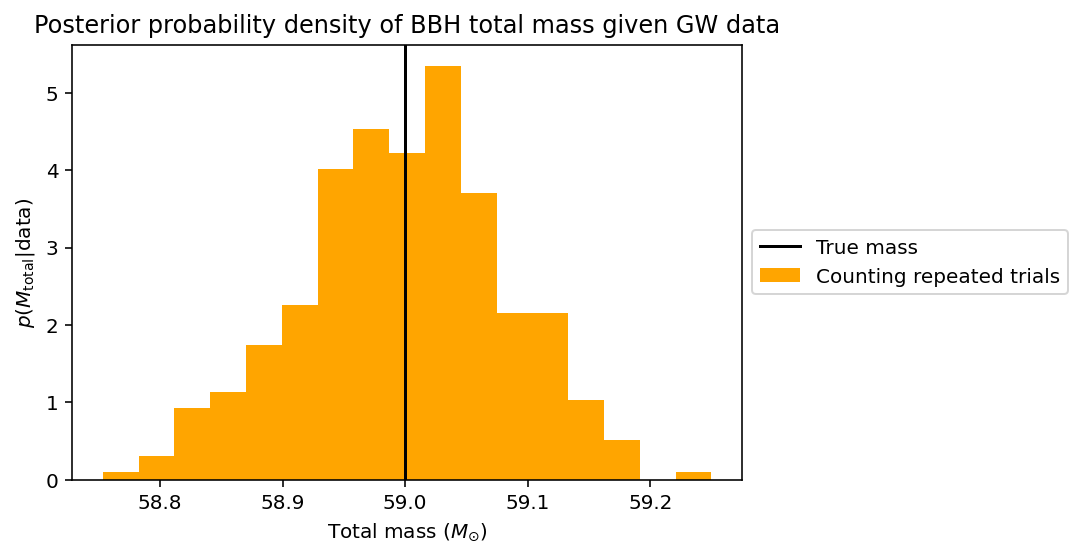

In [20]:
plt.hist(measurement_table['total mass'],bins='auto',density=True,label='Counting repeated trials',color='orange')
plt.axvline(mtotal_new,c='black',label='True mass')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Total mass ($M_{\odot})$")
plt.ylabel("$p(M_{\mathrm{total}}|$data)")
plt.ylim(0)
plt.title("Posterior probability density of BBH total mass given GW data")
plt.show()

In [21]:
idx_mtotal_new  = np.where(np.abs(BBH_masses-61) < 0.01)

In [22]:
likelihood_table = dataframe[dataframe.index.isin(idx_mtotal_new[0])]

In [23]:
likelihood_table

,total mass,strain_data,noise,signal
7,60.996587,-4.424684e-21+2.369181e-23j,1.861490e-24+1.103197e-24j,-4.426546e-21+2.258862e-23j
76,60.999018,-4.414064e-21+1.624956e-23j,1.270895e-23-6.341673e-24j,-4.426773e-21+2.259123e-23j
82,60.993218,-4.433650e-21+1.602501e-23j,-7.417879e-24-6.559982e-24j,-4.426232e-21+2.258499e-23j
297,60.990333,-4.422441e-21+2.799986e-23j,3.522419e-24+5.417973e-24j,-4.425963e-21+2.258189e-23j
437,61.008147,-4.431378e-21+2.236973e-23j,-3.754306e-24-2.313251e-25j,-4.427624e-21+2.260105e-23j
...,...,...,...,...
4998885,60.999076,-4.423789e-21+2.474783e-23j,2.988735e-24+2.156535e-24j,-4.426778e-21+2.259129e-23j
4999344,60.990531,-4.431508e-21+3.911014e-23j,-5.526072e-24+1.652804e-23j,-4.425981e-21+2.258210e-23j
4999397,60.996262,-4.434726e-21+1.743349e-23j,-8.209934e-24-5.154776e-24j,-4.426516e-21+2.258827e-23j
4999689,60.991118,-4.432602e-21+1.242291e-23j,-6.565395e-24-1.015982e-23j,-4.426036e-21+2.258273e-23j


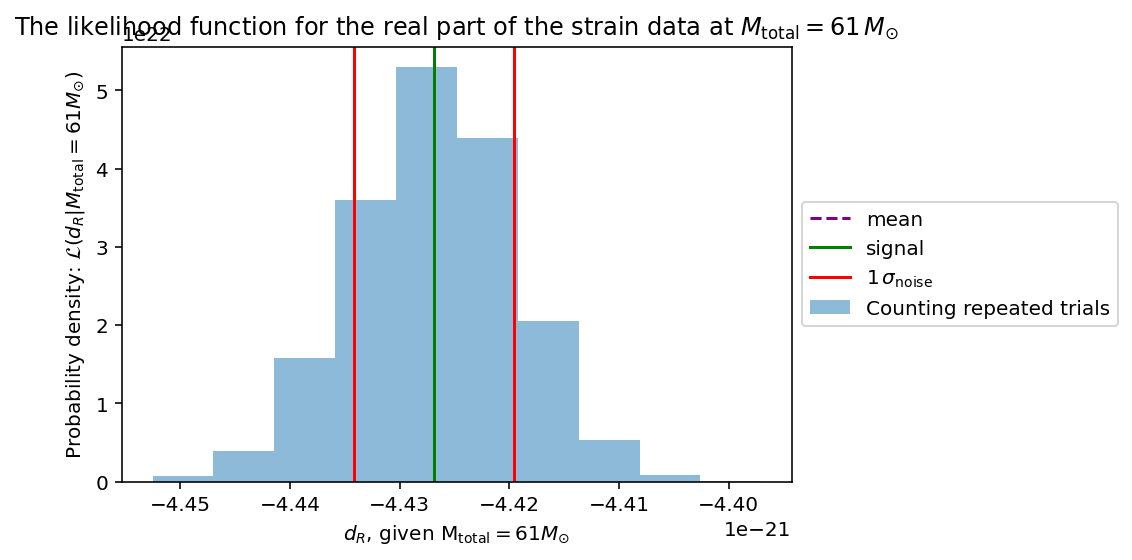

In [24]:
signal = GW_signal(61)[0] 
deltaF = 1/4.
noise_var = lalsim.SimNoisePSDaLIGOZeroDetLowPower(data_frequency) / (4*deltaF)

_d_mean = np.mean(np.real(likelihood_table['strain_data']))
plt.axvline(_d_mean,color='purple',linestyle='--',label='mean')
plt.axvline(signal.real,color='green',label='signal')
plt.axvline(_d_mean - noise_var**0.5,color='red',label='$1\,\sigma_{\mathrm{noise}}$')
plt.axvline(_d_mean + noise_var**0.5,color='red')

plt.hist(np.real(likelihood_table['strain_data']),density=True,label='Counting repeated trials',alpha=0.5)
plt.xlabel("$d_R$, given M$_{\mathrm{total}} = 61M_{\odot}$")
plt.ylabel("Probability density: $\mathcal{L}(d_R|M_{\mathrm{total}} = 61M_{\odot})$")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("The likelihood function for the real part of the strain data at $M_{\mathrm{total}}=61\,M_{\odot}$")
plt.show()

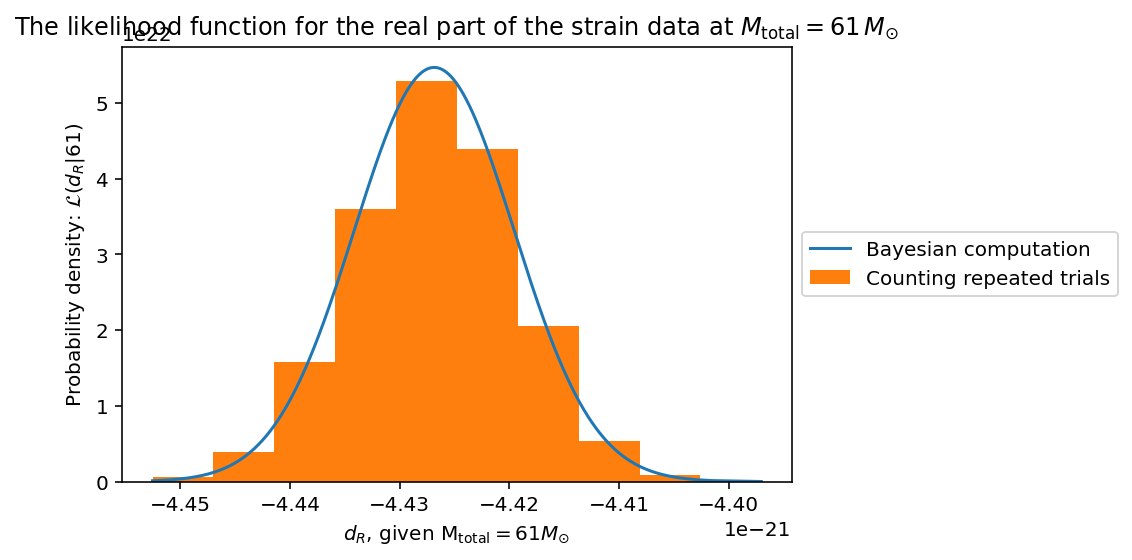

In [25]:
signal = GW_signal(61)[0] 

likelihoods=np.array([lnL_re(_s,signal) for _s in np.sort(np.real(likelihood_table['strain_data']))])

plt.plot(np.sort(np.real(likelihood_table['strain_data'])), np.exp(likelihoods),label='Bayesian computation')
plt.hist(np.real(likelihood_table['strain_data']),density=True,label='Counting repeated trials')
plt.xlabel("$d_R$, given M$_{\mathrm{total}} = 61M_{\odot}$")
plt.ylabel("Probability density: $\mathcal{L}(d_R|61)$")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("The likelihood function for the real part of the strain data at $M_{\mathrm{total}}=61\,M_{\odot}$")
plt.show()

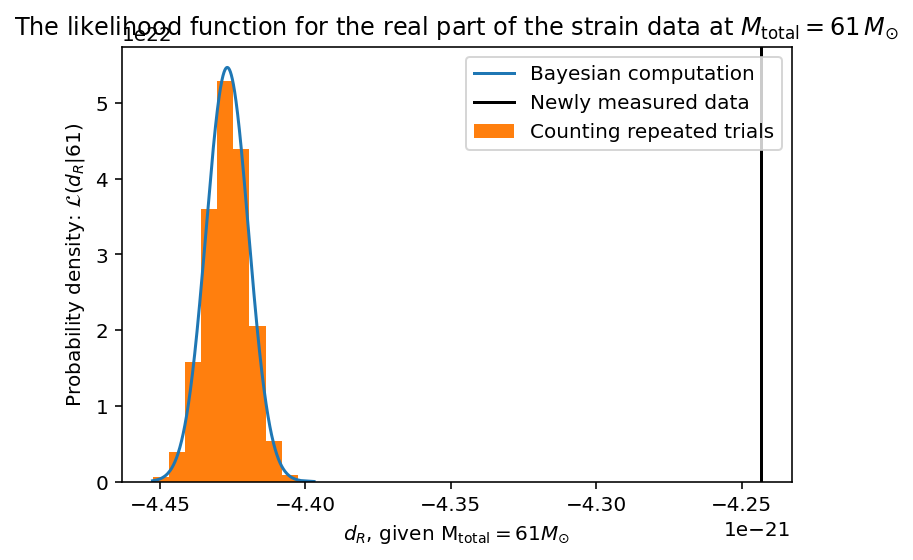

In [26]:
signal = GW_signal(61)[0] 

likelihoods=np.array([lnL_re(_s,signal) for _s in np.sort(np.real(likelihood_table['strain_data']))])

plt.plot(np.sort(np.real(likelihood_table['strain_data'])), np.exp(likelihoods),label='Bayesian computation')
plt.hist(np.real(likelihood_table['strain_data']),density=True,label='Counting repeated trials')
plt.axvline(strain_data_new.real,label='Newly measured data',color='black')

plt.xlabel("$d_R$, given M$_{\mathrm{total}} = 61M_{\odot}$")
plt.ylabel("Probability density: $\mathcal{L}(d_R|61)$")
plt.legend(loc=1)
plt.title("The likelihood function for the real part of the strain data at $M_{\mathrm{total}}=61\,M_{\odot}$")
plt.show()

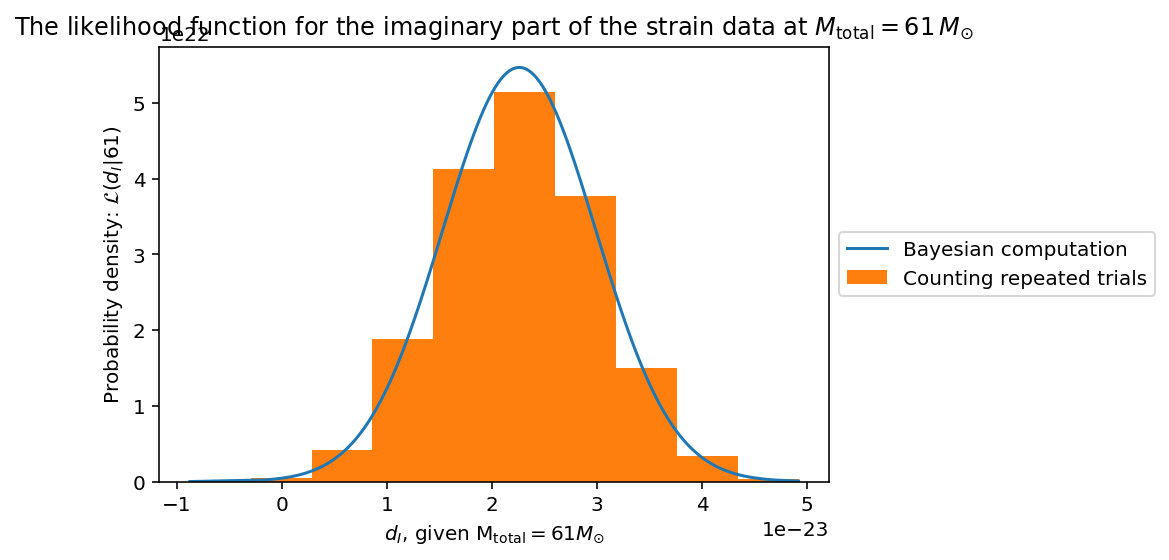

In [27]:
signal = GW_signal(61)[0] 

likelihoods=np.array([lnL_im(1j*_s,signal) for _s in np.sort(np.imag(likelihood_table['strain_data']))])

plt.plot(np.sort(np.imag(likelihood_table['strain_data'])), np.exp(likelihoods),label='Bayesian computation')
plt.hist(np.imag(likelihood_table['strain_data']),density=True,label='Counting repeated trials')
plt.xlabel("$d_I$, given M$_{\mathrm{total}} = 61M_{\odot}$")
plt.ylabel("Probability density: $\mathcal{L}(d_I|61)$")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("The likelihood function for the imaginary part of the strain data at $M_{\mathrm{total}}=61\,M_{\odot}$")
plt.show()

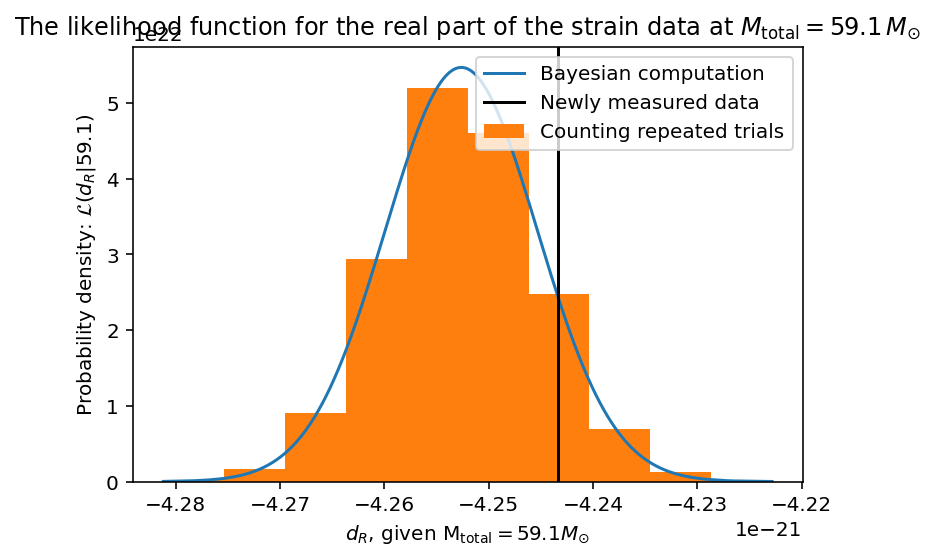

In [28]:
_idx_mtotal_new  = np.where(np.abs(BBH_masses-59.1) < 0.01)
_likelihood_table = dataframe[dataframe.index.isin(_idx_mtotal_new[0])]
signal = GW_signal(59.1)[0] 

likelihoods=np.array([lnL_re(_s,signal) for _s in np.sort(np.real(_likelihood_table['strain_data']))])

plt.plot(np.sort(np.real(_likelihood_table['strain_data'])), np.exp(likelihoods),label='Bayesian computation')
plt.hist(np.real(_likelihood_table['strain_data']),density=True,label='Counting repeated trials')
plt.axvline(strain_data_new.real,label='Newly measured data',color='black')

plt.xlabel("$d_R$, given M$_{\mathrm{total}} = 59.1M_{\odot}$")
plt.ylabel("Probability density: $\mathcal{L}(d_R|59.1)$")
plt.legend(loc=1)
plt.title("The likelihood function for the real part of the strain data at $M_{\mathrm{total}}=59.1\,M_{\odot}$")
plt.show()

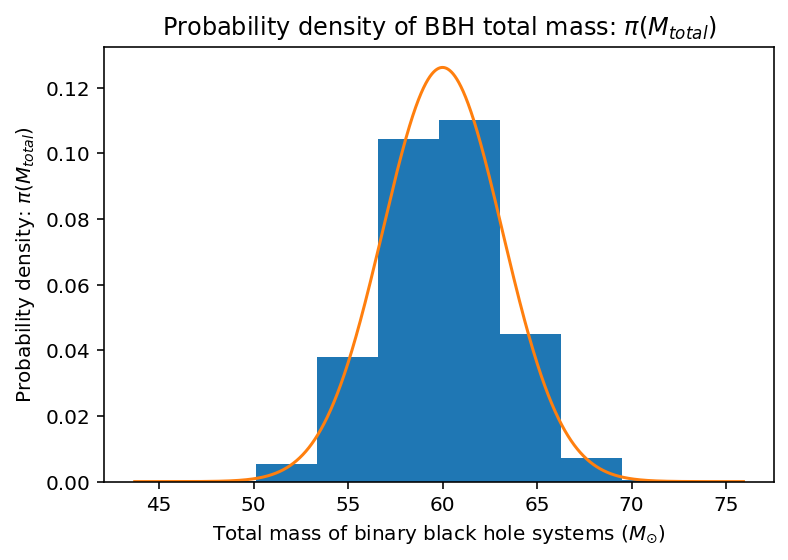

In [29]:
plt.hist(BBH_masses, density=True)
plt.plot(np.sort(BBH_masses), np.exp(lnpi(np.sort(BBH_masses))))
plt.xlabel(r"Total mass of binary black hole systems $(M_{\odot})$")
plt.title(r"Probability density of BBH total mass: $\pi(M_{total})$")
plt.ylabel("Probability density: $\pi(M_{total})$")
plt.show()

In [30]:
# Let's compute the posterior probability density for a selection of masses 
# We should get the same shape as the histogram and the precise numerical values for the probability density
m_tot_list = np.linspace(58.5,59.5,1000)

ln_posterior = np.array([ln_p_mtotal_given_data(_m,strain_data_new) for _m in m_tot_list])

ln_evidence = ln_Z(ln_posterior,(m_tot_list[1]-m_tot_list[0]))

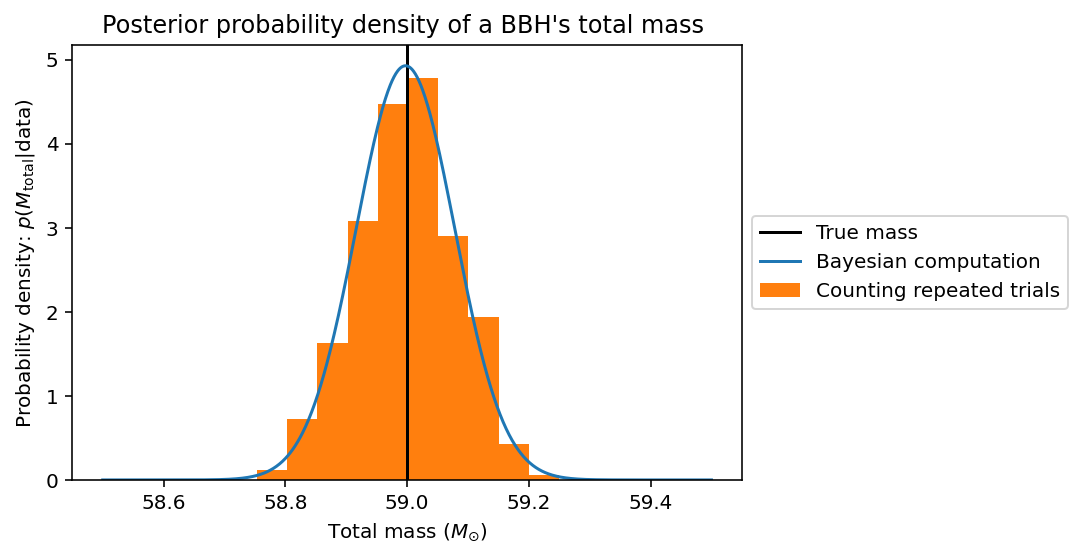

In [31]:
plt.axvline(mtotal_new,c='black',label='True mass')
plt.plot(m_tot_list, np.exp(ln_posterior)/np.exp(ln_evidence),label='Bayesian computation')
plt.hist(measurement_table['total mass'],density=True,label='Counting repeated trials')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Total mass ($M_{\odot})$")
plt.ylabel("Probability density: $p(M_{\mathrm{total}}|$data)")
plt.ylim(0)
plt.title("Posterior probability density of a BBH's total mass ")
plt.show()

(-2e-23, 5e-23)

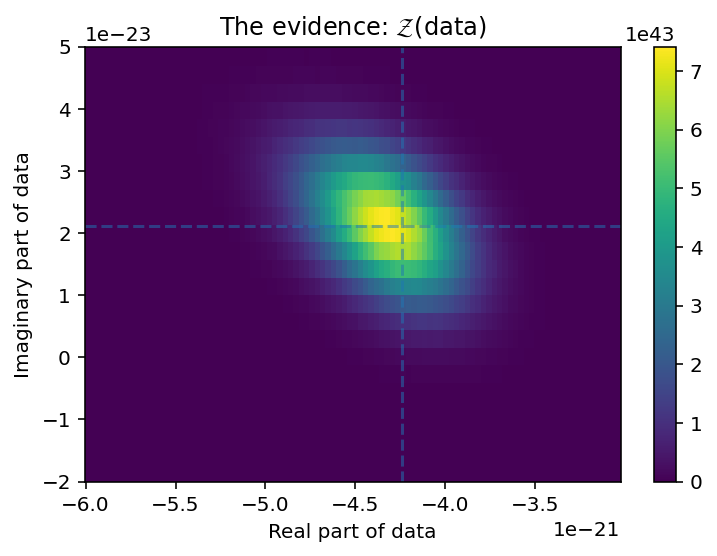

In [32]:
### Plot the evidence (probability density of the strain data) ##############
plt.hist2d(np.real(strain_data), np.imag(strain_data),density=True,bins=100)
plt.xlabel("Real part of data")
plt.ylabel("Imaginary part of data")
plt.colorbar()
plt.axvline(strain_data_new.real,alpha=0.5,linestyle='--')
plt.axhline(strain_data_new.imag,alpha=0.5,linestyle='--')
plt.title("The evidence: $\mathcal{Z}$(data)")
plt.ylim(-2e-23,5e-23)

In [33]:
np.exp(ln_evidence)

7.257557127023264e+43

In [34]:
# Comptue the evidence that the data are just noise 
ln_noise_evidence = lnL_noise_only(strain_data_new)

In [35]:
# Compute a bayes factor to perform a simple hypothesis test: signal vs noise
ln_Bayes_factor = ln_evidence - ln_noise_evidence

In [36]:
print(ln_Bayes_factor)

[169248.08273213]
